In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
#%matplotlib inline

## Preprocessing for the jupyter notebook

In [3]:
########################################################################################################
# Pre-processing
########################################################################################################
# Define the path and get all json files
path = "../data/clean-dataset/"
all_files = glob.glob(os.path.join(path, "clean_*.json"))

# Read all files and concatenate into one DataFrame
dfs = []
for file in all_files :
    # Each JSON file contains one JSON per line
    df = pd.read_json(file, lines=True)
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)

# Convert date columns to datetime objects
data['date'] = pd.to_datetime(data['date'])
data['planned_arrival'] = pd.to_datetime(data['planned_arrival'])
data['real_arrival'] = pd.to_datetime(data['real_arrival'])

# Use IQR (Interquartile Range) Method to filter out statistical outliers.

def remove_outliers(df, col, multiplier=1.5) :
    # Remove outliers from a DataFrame column based on the IQR method.
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - multiplier * iqr
    upper_bound = q3 + multiplier * iqr
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]


# Use the function to remove outliers in arrival_delay_min
data_clean_iqr = remove_outliers(data, 'arrival_delay_min')



data_no_nan = data_clean_iqr.dropna(
    subset=['arrival_delay_min', 'temperature_2m', 'precipitation', 'snowfall', 'wind_speed_10m', 'cloudcover',
            'weathercode'])

# %%% Create new variables (categorical bins) for plotting

# Precipitation bins in mm (adjust as needed).
# Bin labels must be one fewer than the number of bin edges
bins = [0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14]
labels = ['0-0.02 mm', '0.02-0.04 mm', '0.04-0.06 mm', '0.06-0.08 mm', '0.08-0.10 mm', '0.10-0.12 mm', '0.12-0.14+ mm']

# Create categorical bins
data_no_nan = data_no_nan.copy()
data_no_nan.loc[:, 'precipitation_category'] = pd.cut(
    data_no_nan['precipitation'],
    bins=bins,
    labels=labels,
    include_lowest=True
)
# Snowfall bins in cm (adjust as needed).
# Bin labels must be one fewer than the number of bin edges
bins = [-0.01, 0, 0.1, 0.5, 1, 2, 5]
labels = ['0 cm', '0-0.1 cm', '0.1-0.5 cm', '0.5-1 cm', '1-2 cm', '2-5 cm']

# Create categorical bins
data_no_nan = data_no_nan.copy()
data_no_nan.loc[:, 'snowfall_category'] = pd.cut(
    data_no_nan['snowfall'],
    bins=bins,
    labels=labels,
    include_lowest=True
)
########################################################################################################
# Extracts the day of the week as a new column
data_no_nan['weekday'] = data_no_nan['date'].dt.day_name()

# Create new columns for month name and month number (to preserve order)
data_no_nan['month'] = data_no_nan['date'].dt.strftime('%B')
data_no_nan['month_num'] = data_no_nan['date'].dt.month
########################################################################################################
# Add original Weather Code description
"""
Weather condition is a numeric code. See table below for details.
WMO Weather interpretation codes (WW)
Code	    Description
0	        Clear sky
1,  2,  3	Mainly clear, partly cloudy, and overcast
45, 48	    Fog and depositing rime fog
51, 53, 55	Drizzle: Light, moderate, and dense intensity
56, 57	    Freezing Drizzle: Light and dense intensity
61, 63, 65	Rain: Slight, moderate and heavy intensity
66, 67	    Freezing Rain: Light and heavy intensity
71, 73, 75	Snow fall: Slight, moderate, and heavy intensity
77	        Snow grains
80, 81, 82	Rain showers: Slight, moderate, and violent
85, 86	    Snow showers slight and heavy
95 *	    Thunderstorm: Slight or moderate
96, 99 *	Thunderstorm with slight and heavy hail
(*) Thunderstorm forecast with hail is only available in Central Europe
"""
# Define the mapping for weather codes to descriptions
weather_mapping = {
    0 : "Clear sky",
    1 : "Mainly clear, partly cloudy, and overcast",
    2 : "Mainly clear, partly cloudy, and overcast",
    3 : "Mainly clear, partly cloudy, and overcast",
    45 : "Fog and depositing rime fog",
    48 : "Fog and depositing rime fog",
    51 : "Drizzle: Light, moderate, and dense intensity",
    53 : "Drizzle: Light, moderate, and dense intensity",
    55 : "Drizzle: Light, moderate, and dense intensity",
    56 : "Freezing Drizzle: Light and dense intensity",
    57 : "Freezing Drizzle: Light and dense intensity",
    61 : "Rain: Slight, moderate and heavy intensity",
    63 : "Rain: Slight, moderate and heavy intensity",
    65 : "Rain: Slight, moderate and heavy intensity",
    66 : "Freezing Rain: Light and heavy intensity",
    67 : "Freezing Rain: Light and heavy intensity",
    71 : "Snow fall: Slight, moderate, and heavy intensity",
    73 : "Snow fall: Slight, moderate, and heavy intensity",
    75 : "Snow fall: Slight, moderate, and heavy intensity",
    77 : "Snow grains",
    80 : "Rain showers: Slight, moderate, and violent",
    81 : "Rain showers: Slight, moderate, and violent",
    82 : "Rain showers: Slight, moderate, and violent",
    85 : "Snow showers slight and heavy",
    86 : "Snow showers slight and heavy",
    95 : "Thunderstorm: Slight or moderate",
    96 : "Thunderstorm with slight and heavy hail",
    99 : "Thunderstorm with slight and heavy hail"
}

# Map the weather codes to their descriptions
data_no_nan['orig_weather_description'] = data_no_nan['weathercode'].map(weather_mapping)

# Optionally, if there might be codes not covered by the mapping, assign 'Unknown'
data_no_nan['orig_weather_description'] = data_no_nan['orig_weather_description'].fillna('Unknown')


########################################################################################################
# Add simplified Weather Code description
def simplified_weather(code) :
    if code == 0 :
        return "Clear"
    elif code in [1, 2, 3] :
        return "Cloudy"
    elif code in [45, 48] :
        return "Fog"
    elif code in [51, 53, 55, 56, 57] :
        return "Drizzle"
    elif code in [61, 63, 65, 66, 67] :
        return "Rain"
    elif code in [71, 73, 75, 77, 85, 86] :
        return "Snow"
    elif code in [95, 96, 99] :
        return "Thunderstorm"
    else :
        return "Unknown"


data_no_nan['simp_weather_description'] = data_no_nan['weathercode'].apply(simplified_weather)

In [4]:
# %%% for data_no_nan2

# Does not limit the upper boundaries
def remove_outliers2(df, col, multiplier=1.5):
    # Remove outliers from a DataFrame column based on the IQR method.
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - multiplier * iqr
    upper_bound = df[col].max()  # Use df[col].max() to work with the provided DataFrame
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# Use the function to remove outliers in arrival_delay_min
data_clean_iqr2 = remove_outliers2(data, 'arrival_delay_min')

data_no_nan2 = data_clean_iqr2.dropna(subset=['arrival_delay_min', 'temperature_2m', 'precipitation', 'snowfall', 'wind_speed_10m', 'cloudcover', 'weathercode'])

# %%%
# Precipitation bins in mm (adjust as needed).
# Bin labels must be one fewer than the number of bin edges

# Create categorical bins
data_no_nan2 = data_no_nan2.copy()
data_no_nan2.loc[:, 'precipitation_category'] = pd.cut(
    data_no_nan2['precipitation'],
    bins=bins,
    labels=labels,
    include_lowest=True
)
# Snowfall bins in cm (adjust as needed).

# Create categorical bins
data_no_nan2 = data_no_nan2.copy()
data_no_nan2.loc[:, 'snowfall_category'] = pd.cut(
    data_no_nan2['snowfall'],
    bins=bins,
    labels=labels,
    include_lowest=True
)
########################################################################################################
# Extracts the day of the week as a new column
data_no_nan2['weekday'] = data_no_nan2['date'].dt.day_name()

# Create new columns for month name and month number (to preserve order)
data_no_nan2['month'] = data_no_nan2['date'].dt.strftime('%B')
data_no_nan2['month_num'] = data_no_nan2['date'].dt.month
########################################################################################################
# Add original Weather Code description

# Map the weather codes to their descriptions
data_no_nan2['orig_weather_description'] = data_no_nan2['weathercode'].map(weather_mapping)

# Optionally, if there might be codes not covered by the mapping, assign 'Unknown'
data_no_nan2['orig_weather_description'] = data_no_nan2['orig_weather_description'].fillna('Unknown')

########################################################################################################
# Add simplified Weather Code description

data_no_nan2['simp_weather_description'] = data_no_nan2['weathercode'].apply(simplified_weather)

In [28]:
data_no_nan.describe()

,date,planned_arrival,real_arrival,arrival_delay_min,temperature_2m,precipitation,snowfall,wind_speed_10m,cloudcover,weathercode,month_num
count,578402,578402,578402,578402.000000,578402.000000,578402.000000,578402.000000,578402.000000,578402.000000,578402.000000,578402.000000
mean,2025-03-11 11:45:09.264491008,2025-03-12 02:28:44.861255680,2025-03-12 02:28:26.645655040,0.190325,6.680387,0.064557,0.003790,6.210656,60.796045,9.820419,2.819584
min,2025-02-15 00:00:00,2025-02-15 00:12:00,2025-02-15 00:13:00,-2.516667,-12.200000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
25%,2025-02-27 00:00:00,2025-02-27 15:07:00,2025-02-27 15:06:00,-0.483333,3.300000,0.000000,0.000000,2.400000,10.000000,0.000000,2.000000
50%,2025-03-11 00:00:00,2025-03-12 00:55:00,2025-03-12 00:54:00,0.133333,6.500000,0.000000,0.000000,4.600000,84.000000,3.000000,3.000000
75%,2025-03-24 00:00:00,2025-03-24 13:13:00,2025-03-24 13:12:00,0.800000,9.800000,0.000000,0.000000,8.300000,100.000000,3.000000,3.000000
max,2025-04-06 00:00:00,2025-04-07 01:52:00,2025-04-07 01:52:00,3.000000,23.100000,7.000000,4.200000,37.000000,100.000000,75.000000,4.000000
std,NaN,NaN,NaN,1.011038,4.740667,0.259418,0.057851,5.328927,42.289805,19.088459,0.589174


In [26]:
data_no_nan2.describe()

,date,planned_arrival,real_arrival,arrival_delay_min,temperature_2m,precipitation,snowfall,wind_speed_10m,cloudcover,weathercode,month_num
count,609415,609415,609415,609415.000000,609415.000000,609415.000000,609415.000000,609415.000000,609415.000000,609415.000000,609415.000000
mean,2025-03-11 12:11:06.840166144,2025-03-12 02:56:48.654627328,2025-03-12 02:56:52.266649088,0.551779,6.685096,0.065311,0.003848,6.212833,60.758836,9.900649,2.820073
min,2025-02-15 00:00:00,2025-02-15 00:12:00,2025-02-15 00:13:00,-2.516667,-12.200000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
25%,2025-02-27 00:00:00,2025-02-27 14:40:00,2025-02-27 14:39:00,-0.433333,3.300000,0.000000,0.000000,2.400000,10.000000,0.000000,2.000000
50%,2025-03-12 00:00:00,2025-03-12 05:39:00,2025-03-12 05:39:00,0.183333,6.500000,0.000000,0.000000,4.600000,84.000000,3.000000,3.000000
75%,2025-03-24 00:00:00,2025-03-24 14:49:00,2025-03-24 14:49:00,0.950000,9.800000,0.000000,0.000000,8.300000,100.000000,3.000000,3.000000
max,2025-04-06 00:00:00,2025-04-07 01:52:00,2025-04-07 01:52:00,219.716667,23.100000,7.000000,4.200000,37.000000,100.000000,75.000000,4.000000
std,NaN,NaN,NaN,2.878646,4.745532,0.260978,0.058322,5.341005,42.323153,19.172439,0.591161


### Box plot for arrival delays grouped by stations

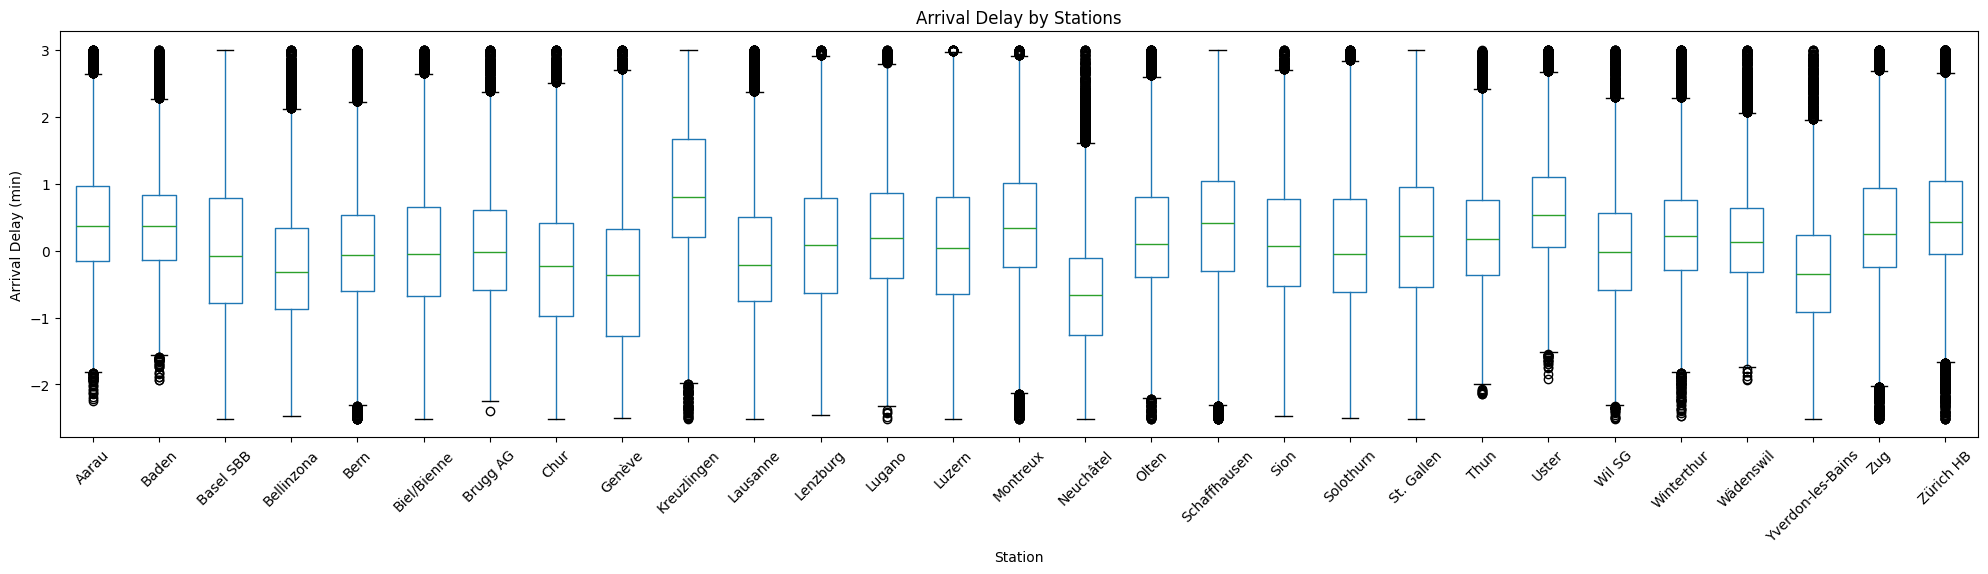

In [3]:
plt.rcParams['figure.figsize'] = (20, 6) # Changes the figure size for all plots
# Creates a box plot for arrival delays grouped by weekday
data_no_nan.boxplot(column='arrival_delay_min', by='station', grid=False)
plt.title("Arrival Delay by Stations")
plt.suptitle("")  # Remove default subtitle
plt.xlabel("Station")
plt.ylabel("Arrival Delay (min)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Research Question 1: How do different weather conditions (e.g., temperature, precipitation, wind speed) influ-ence train delays?

### Box plot for arrival delays grouped by snowfall category

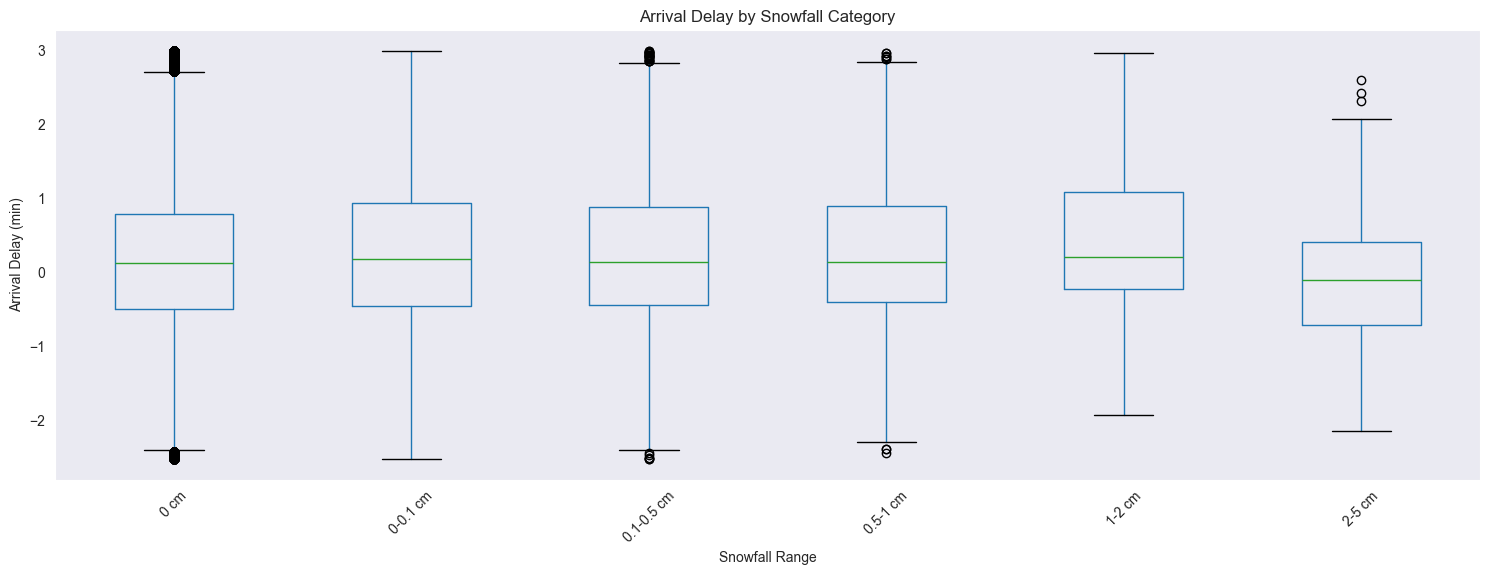

In [6]:
plt.rcParams['figure.figsize'] = (15, 6) # Changes the figure size for all plots
data_no_nan.boxplot(
    column='arrival_delay_min',
    by='snowfall_category',
    grid=False
)
plt.title("Arrival Delay by Snowfall Category")
plt.suptitle("")  # Remove the default subtitle
plt.xlabel("Snowfall Range")
plt.ylabel("Arrival Delay (min)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Box plot for arrival delays grouped by weekday

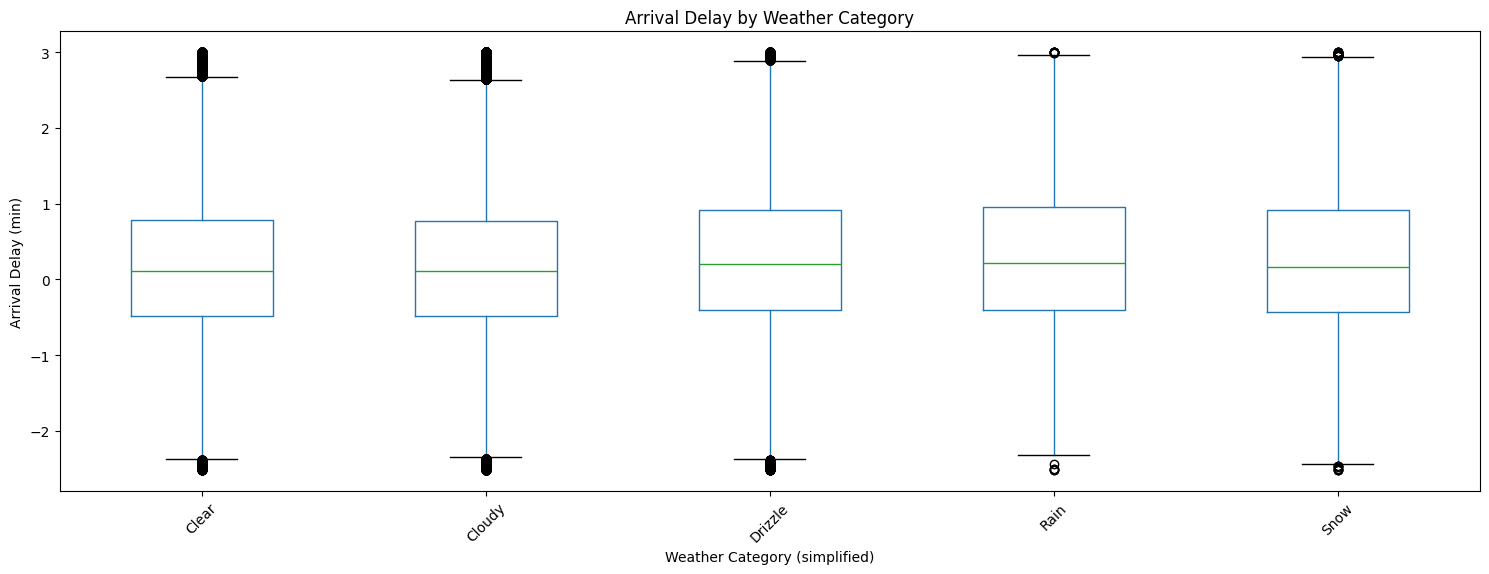

In [30]:
data_no_nan.boxplot(column='arrival_delay_min', by='simp_weather_description', grid=False)
plt.title("Arrival Delay by Weather Category")
plt.suptitle("")  # Remove default subtitle
plt.xlabel("Weather Category (simplified)")
plt.ylabel("Arrival Delay (min)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Boxplot: Arrival Delay vs Precipitation

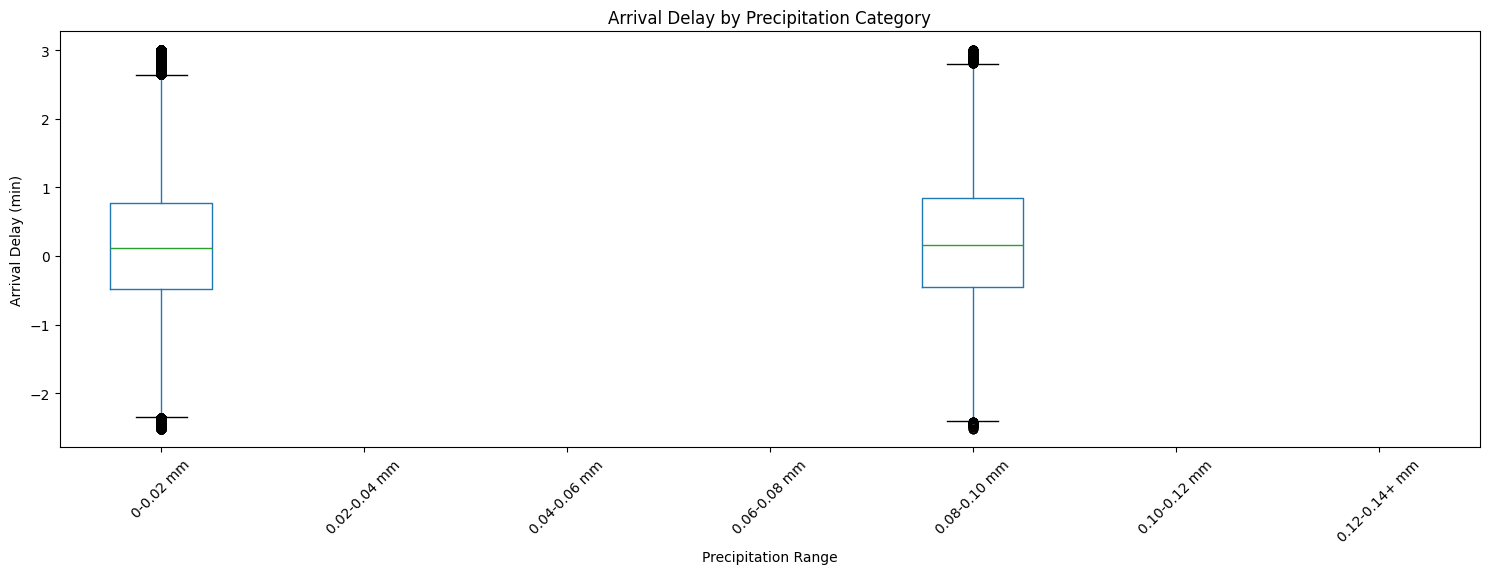

In [38]:
data_no_nan.boxplot(
    column='arrival_delay_min',
    by='precipitation_category',
    grid=False
)
plt.title("Arrival Delay by Precipitation Category")
plt.suptitle("")  # Remove the default subtitle
plt.xlabel("Precipitation Range")
plt.ylabel("Arrival Delay (min)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Heat Map for temperature, precipitation, and wind speed vs. arrival delay.

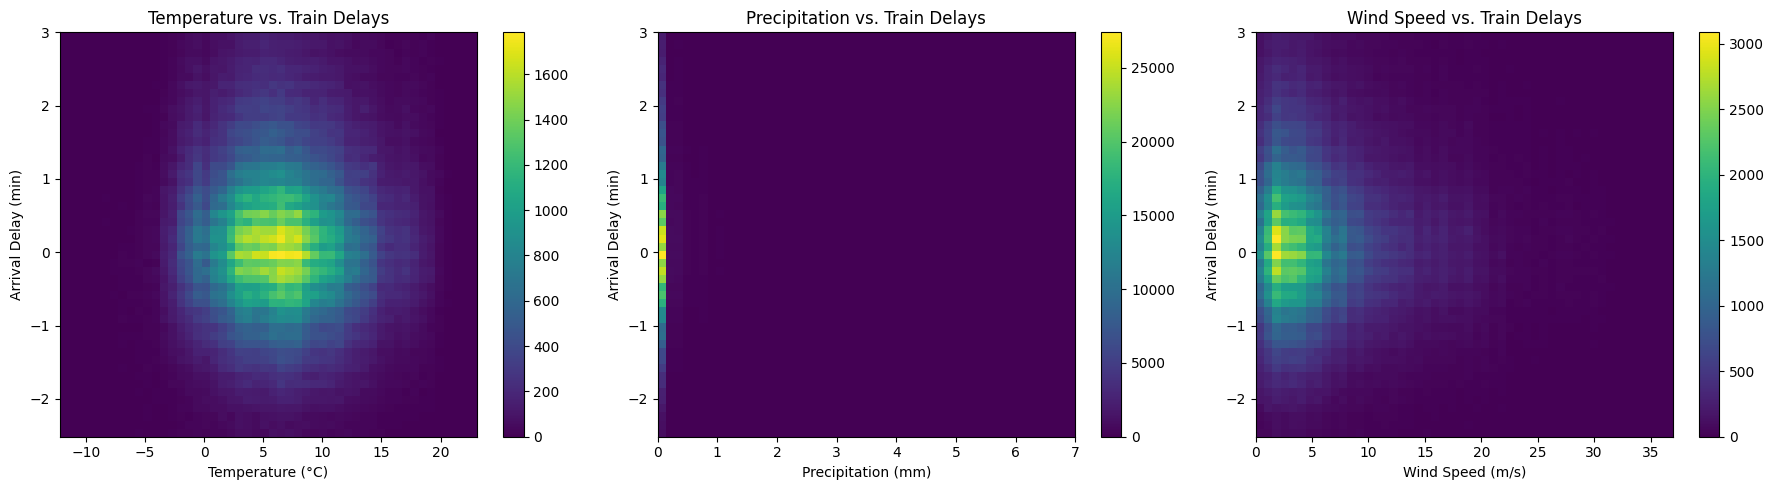

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Temperature vs. Arrival Delay heat map
h_temp = axes[0].hist2d(data_no_nan['temperature_2m'],
                          data_no_nan['arrival_delay_min'],
                          bins=50, cmap='viridis')
axes[0].set_title("Temperature vs. Train Delays")
axes[0].set_xlabel("Temperature (°C)")
axes[0].set_ylabel("Arrival Delay (min)")
plt.colorbar(h_temp[3], ax=axes[0])

# Precipitation vs. Arrival Delay heat map
h_precip = axes[1].hist2d(data_no_nan['precipitation'],
                            data_no_nan['arrival_delay_min'],
                            bins=50, cmap='viridis')
axes[1].set_title("Precipitation vs. Train Delays")
axes[1].set_xlabel("Precipitation (mm)")
axes[1].set_ylabel("Arrival Delay (min)")
plt.colorbar(h_precip[3], ax=axes[1])

# Wind Speed vs. Arrival Delay heat map
h_wind = axes[2].hist2d(data_no_nan['wind_speed_10m'],
                          data_no_nan['arrival_delay_min'],
                          bins=50, cmap='viridis')
axes[2].set_title("Wind Speed vs. Train Delays")
axes[2].set_xlabel("Wind Speed (m/s)")
axes[2].set_ylabel("Arrival Delay (min)")
plt.colorbar(h_wind[3], ax=axes[2])

plt.tight_layout()
plt.show()

When the 2D histogram/heat map (Temperature vs. Train Delays, Precipitation vs. Train Delays, etc.) was plotted, the color intensity was primarily used to reflect the number of data points present in each bin—so it is possible that rare conditions (such as snow, if only observed on a few days) would not be registered as significant. Average or median delay behavior is not necessarily revealed by this approach. Instead, a better sense of how conditions correlate with delays is achieved by focusing on aggregated statistics (mean or median delay) within bins or categories, even if those conditions occur infrequently.

### Scatter Plots for Temperature, Precipitation, and Wind Speed vs. Arrival Delay

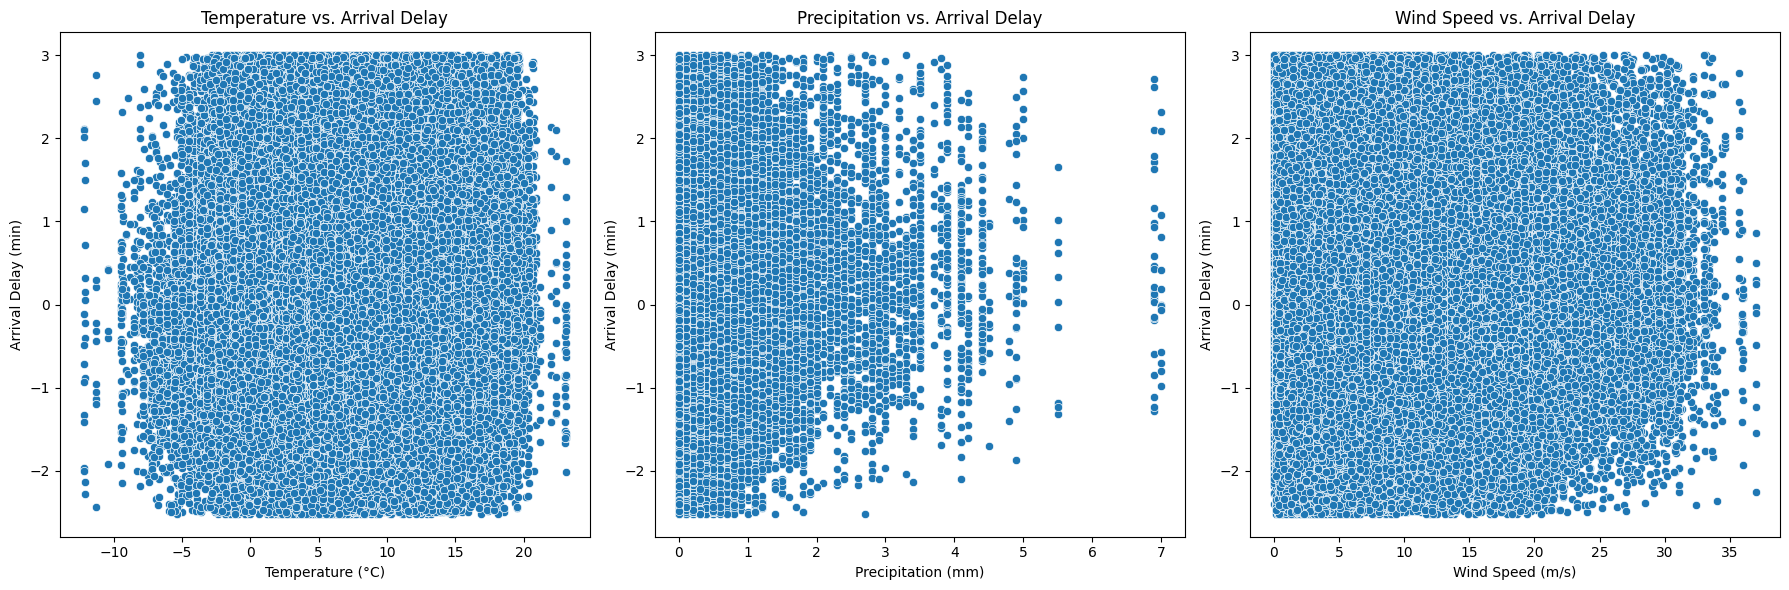

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.scatterplot(data=data_no_nan, x="temperature_2m", y="arrival_delay_min", ax=axes[0])
axes[0].set_title("Temperature vs. Arrival Delay")
axes[0].set_xlabel("Temperature (°C)")
axes[0].set_ylabel("Arrival Delay (min)")

sns.scatterplot(data=data_no_nan, x="precipitation", y="arrival_delay_min", ax=axes[1])
axes[1].set_title("Precipitation vs. Arrival Delay")
axes[1].set_xlabel("Precipitation (mm)")
axes[1].set_ylabel("Arrival Delay (min)")

sns.scatterplot(data=data_no_nan, x="wind_speed_10m", y="arrival_delay_min", ax=axes[2])
axes[2].set_title("Wind Speed vs. Arrival Delay")
axes[2].set_xlabel("Wind Speed (m/s)")
axes[2].set_ylabel("Arrival Delay (min)")

plt.tight_layout()
plt.show()


# Research Question 2: Is there a seasonal variation in train punctuality related to weather conditions?

### Line plot of average daily delays

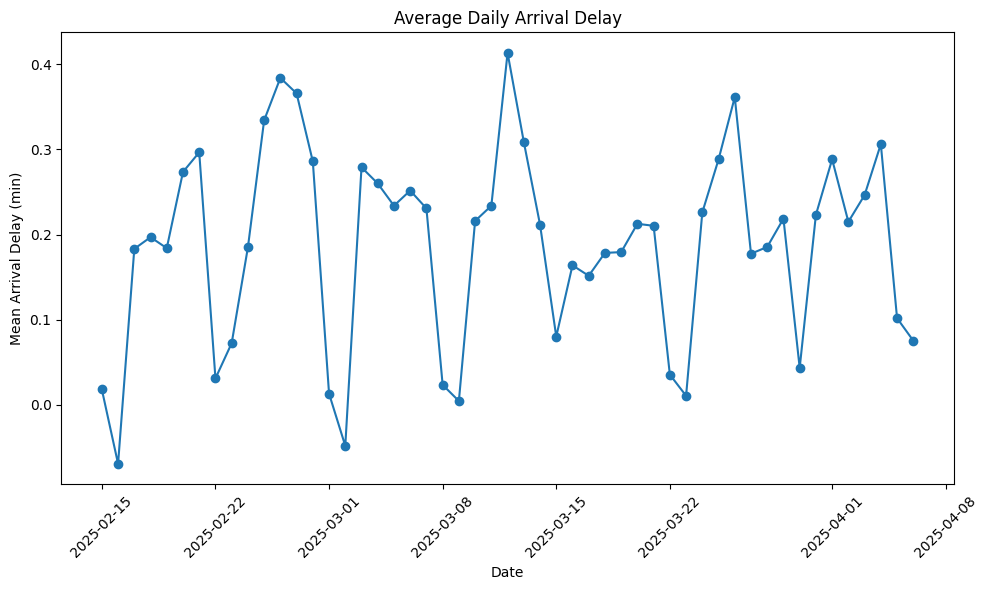

In [33]:
# Group by date, compute mean delay
daily_delays = data_no_nan.groupby(data_no_nan["date"].dt.date)["arrival_delay_min"].mean()

plt.figure(figsize=(10, 6))
daily_delays.plot(marker="o")
plt.title("Average Daily Arrival Delay")
plt.xlabel("Date")
plt.ylabel("Mean Arrival Delay (min)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Boxplot: Arrival Delay vs Month

<Figure size 1200x600 with 0 Axes>

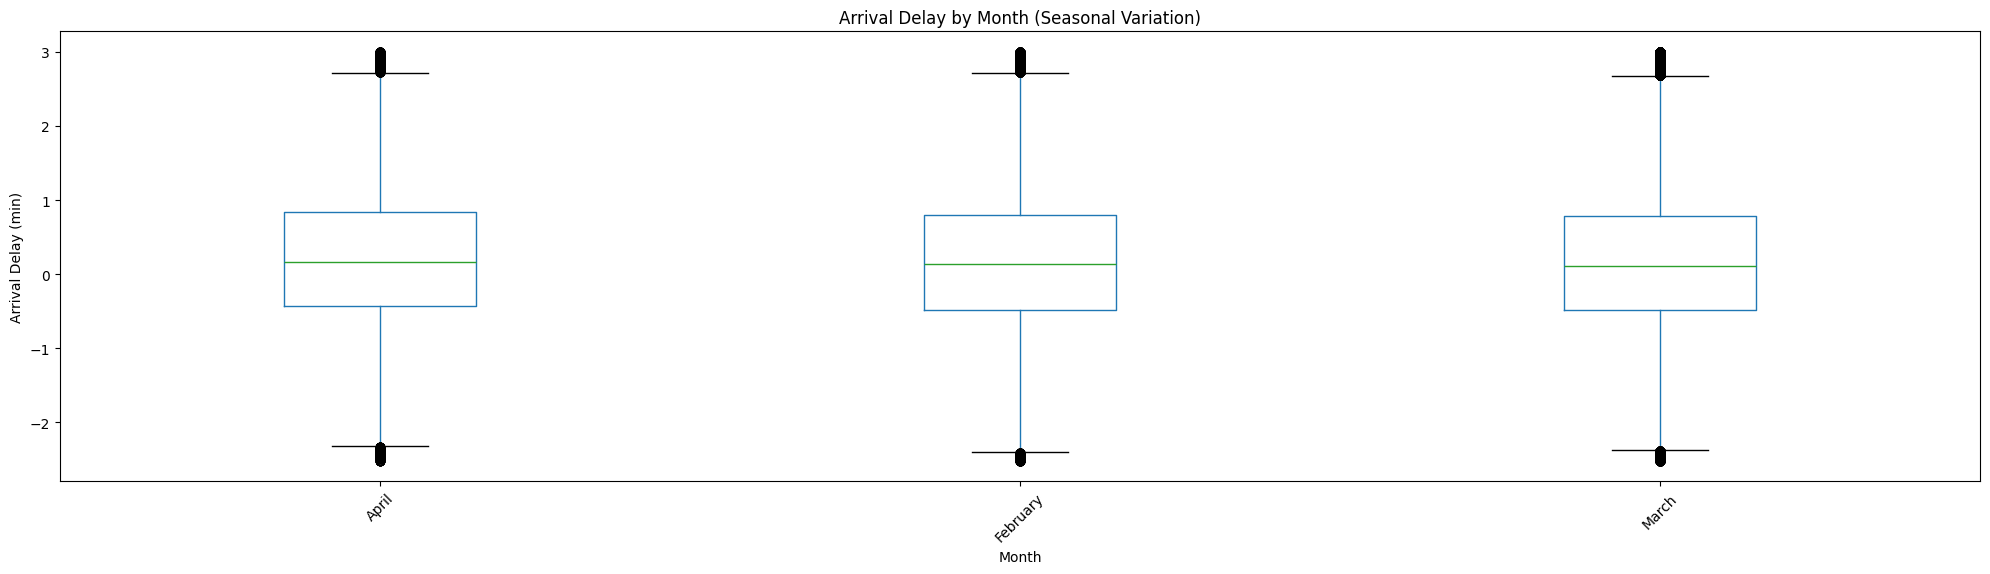

In [15]:
# Sort the data by month number so that the boxplot displays months in calendar order.
data_clean_iqr_sorted = data_no_nan.sort_values('month_num')

plt.figure(figsize=(12,6))
data_clean_iqr_sorted.boxplot(column='arrival_delay_min', by='month', grid=False)
plt.title("Arrival Delay by Month (Seasonal Variation)")
plt.xlabel("Month")
plt.ylabel("Arrival Delay (min)")
plt.suptitle("")  # Remove the automatic subtitle
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Box Plot of Arrival Delays by Day of the Week

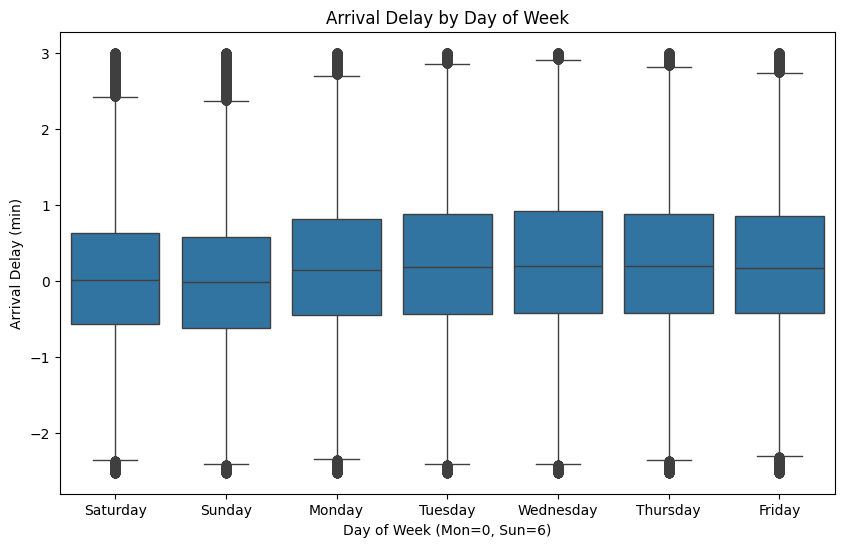

In [16]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_no_nan, x="weekday", y="arrival_delay_min")
plt.title("Arrival Delay by Day of Week")
plt.xlabel("Day of Week (Mon=0, Sun=6)")
plt.ylabel("Arrival Delay (min)")
plt.show()

### Distribution of the daily counts of outlier events (more extreme events)

This code calculates the IQR‐based upper bound for outliers in the arrival_delay_min column, flags which events exceed the upper bound, and then - for each of the three grouping variables i.e.
•	simp_weather_description
•	precipitation_category
•	snowfall_category)
it groups the data by date and the category, counts the number of outlier events per day, and then plots a boxplot of these daily counts. In the boxplot, each box represents the distribution of daily outlier counts for one category value.

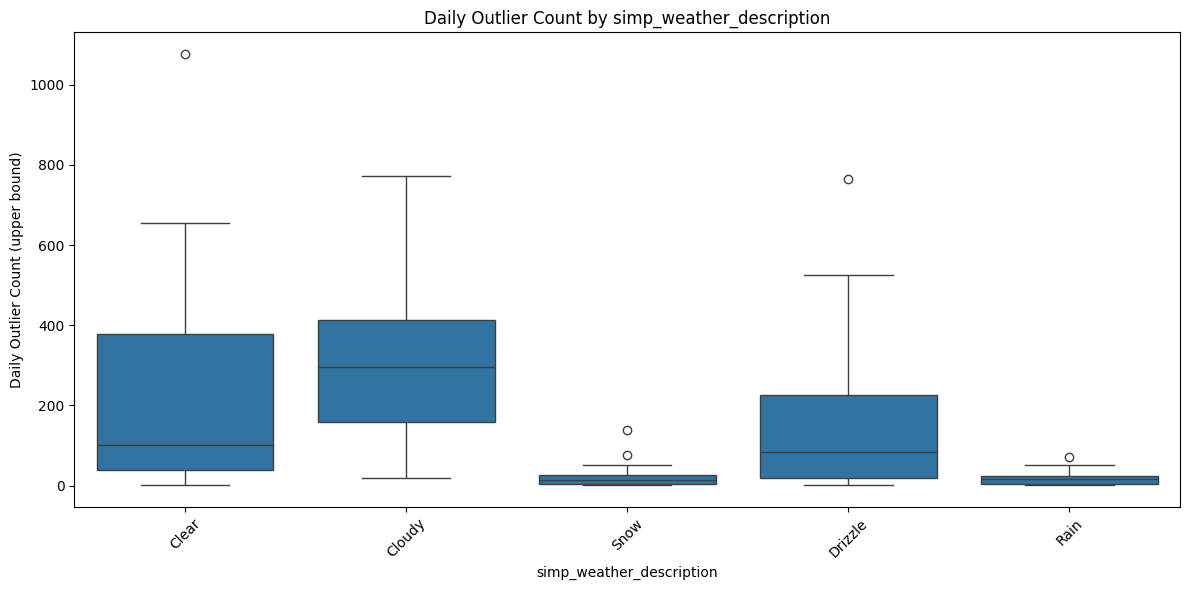

C:\Users\tobia\AppData\Local\Temp\ipykernel_1504\3246115381.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = outliers.groupby(['date', group_col]).size().reset_index(name='outlier_count')


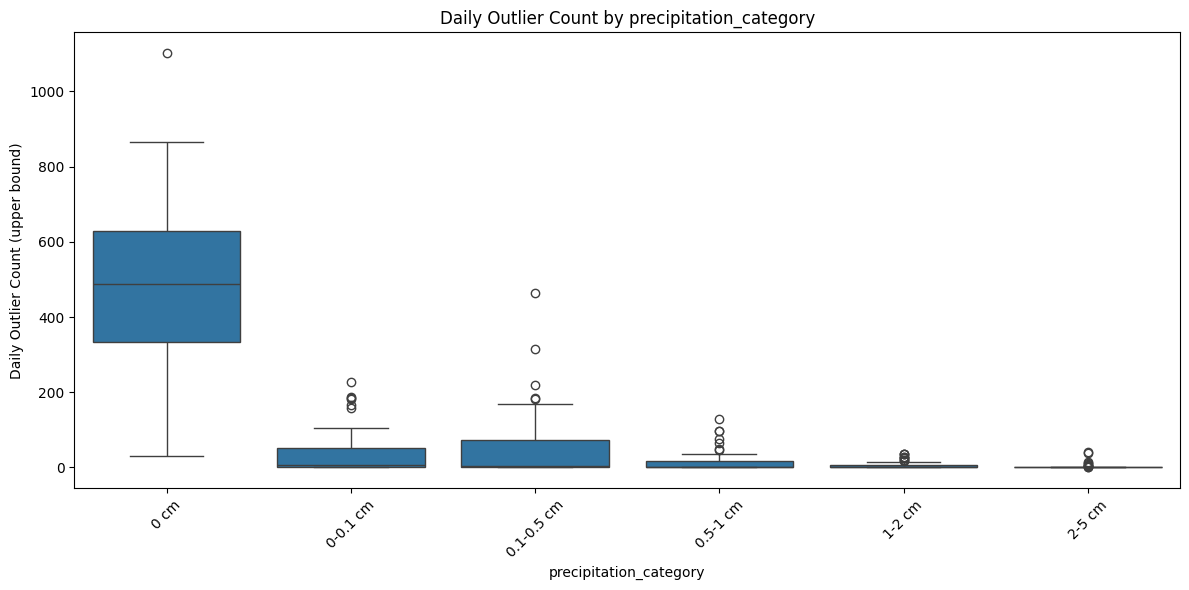

C:\Users\tobia\AppData\Local\Temp\ipykernel_1504\3246115381.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = outliers.groupby(['date', group_col]).size().reset_index(name='outlier_count')


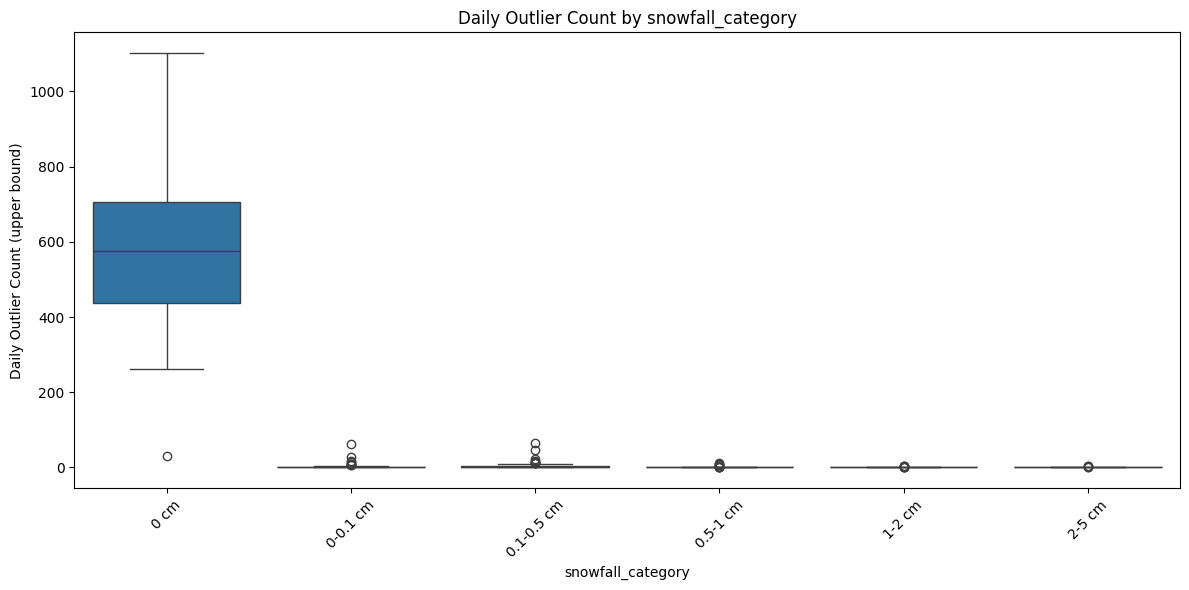

In [43]:
# Calculate the IQR-based upper bound for arrival_delay_min
q1 = data_no_nan2['arrival_delay_min'].quantile(0.25)
q3 = data_no_nan2['arrival_delay_min'].quantile(0.75)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr

# Create an indicator column for outlier events
data_no_nan2['is_outlier'] = data_no_nan2['arrival_delay_min'] > upper_bound

def plot_boxplot_per_category(df, group_col, plot_title):
    """
    For a given grouping column, counts the number of outlier events (per day)
    and plots their distribution as a boxplot.
    """
    # Filter only the outlier events
    outliers = df[df['is_outlier']]
    
    # Group by 'date' and the chosen category, then count the number of outlier events per day for each category value.
    counts = outliers.groupby(['date', group_col]).size().reset_index(name='outlier_count')
    
    # Create a boxplot: x-axis is the grouping variable, y-axis is the daily count of outliers.
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=group_col, y='outlier_count', data=counts)
    plt.title(plot_title)
    plt.xlabel(group_col)
    plt.ylabel("Daily Outlier Count (upper bound)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot boxplots for each of the specified grouping variables
plot_boxplot_per_category(data_no_nan2, 'simp_weather_description', "Daily Outlier Count by simp_weather_description")
plot_boxplot_per_category(data_no_nan2, 'precipitation_category', "Daily Outlier Count by precipitation_category")
plot_boxplot_per_category(data_no_nan2, 'snowfall_category', "Daily Outlier Count by snowfall_category")